In [1]:
%pip install numpy manim matplotlib tensorflow pandas opencv-python scikit-learn 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random

# Step 1: Load and preprocess the dataset
DATA_DIR = r"C:\Users\User\Documents\VS_Code\Cancer_Project\melanoma_cancer_dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

split_ratio = 0.8


os.makedirs(os.path.join(TRAIN_DIR, 'benign'), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'malignant'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'benign'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'malignant'), exist_ok=True)


benign_files = [f for f in os.listdir(os.path.join(DATA_DIR, 'benign')) 
                if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]
malignant_files = [f for f in os.listdir(os.path.join(DATA_DIR, 'malignant')) 
                   if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]


random.shuffle(benign_files)
random.shuffle(malignant_files)


def split_data(files, split_ratio):
    split_point = int(len(files) * split_ratio)
    train_files = files[:split_point]
    test_files = files[split_point:]
    return train_files, test_files
benign_train, benign_test = split_data(benign_files, split_ratio)
malignant_train, malignant_test = split_data(malignant_files, split_ratio)


def copy_files(files, source_dir, target_dir):
    for file in files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(target_dir, file))


copy_files(benign_train, os.path.join(DATA_DIR, 'benign'), os.path.join(TRAIN_DIR, 'benign'))
copy_files(benign_test, os.path.join(DATA_DIR, 'benign'), os.path.join(TEST_DIR, 'benign'))


copy_files(malignant_train, os.path.join(DATA_DIR, 'malignant'), os.path.join(TRAIN_DIR, 'malignant'))
copy_files(malignant_test, os.path.join(DATA_DIR, 'malignant'), os.path.join(TEST_DIR, 'malignant'))


KeyboardInterrupt



In [3]:
# Recursively find all image files in subdirectories
image_files = []
for root, _, files in os.walk(DATA_DIR):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
            image_files.append(os.path.join(root, file))

# Print image sizes for the first 5 images
for i, image_file in enumerate(image_files[:5]):
    with Image.open(image_file) as img:
        print(f"Image {i+1} size:", img.size)


Image 1 size: (300, 300)
Image 2 size: (300, 300)
Image 3 size: (300, 300)
Image 4 size: (300, 300)
Image 5 size: (300, 300)


In [ ]:
# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,  # Reduced from 30
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1,  # Reduced from 0.2
    shear_range=0.1,  # Reduced from 0.2
    zoom_range=0.2,  # Reduced from 0.3
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # No augmentation for test set

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

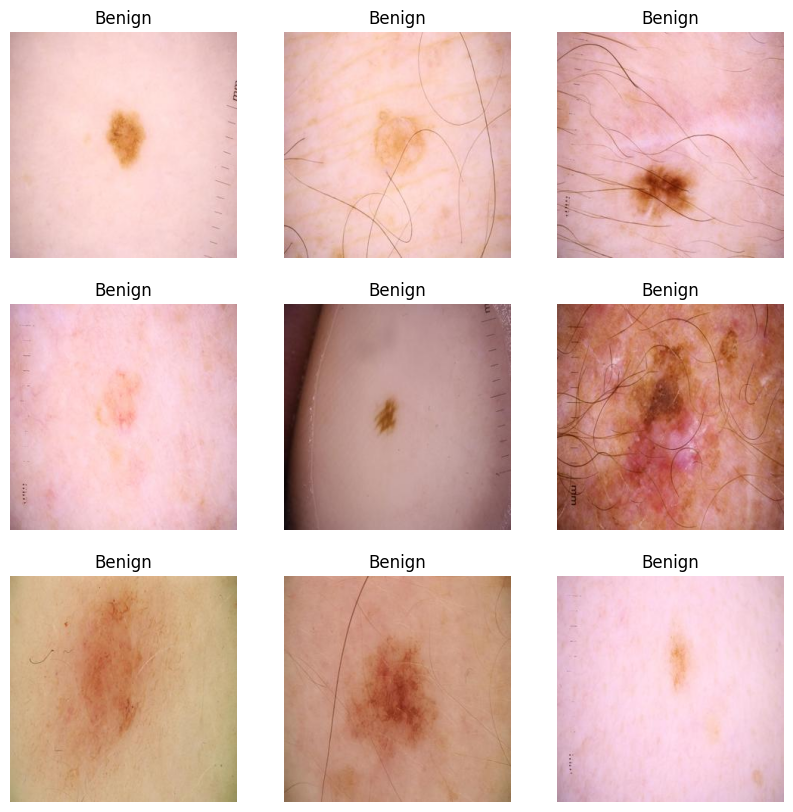

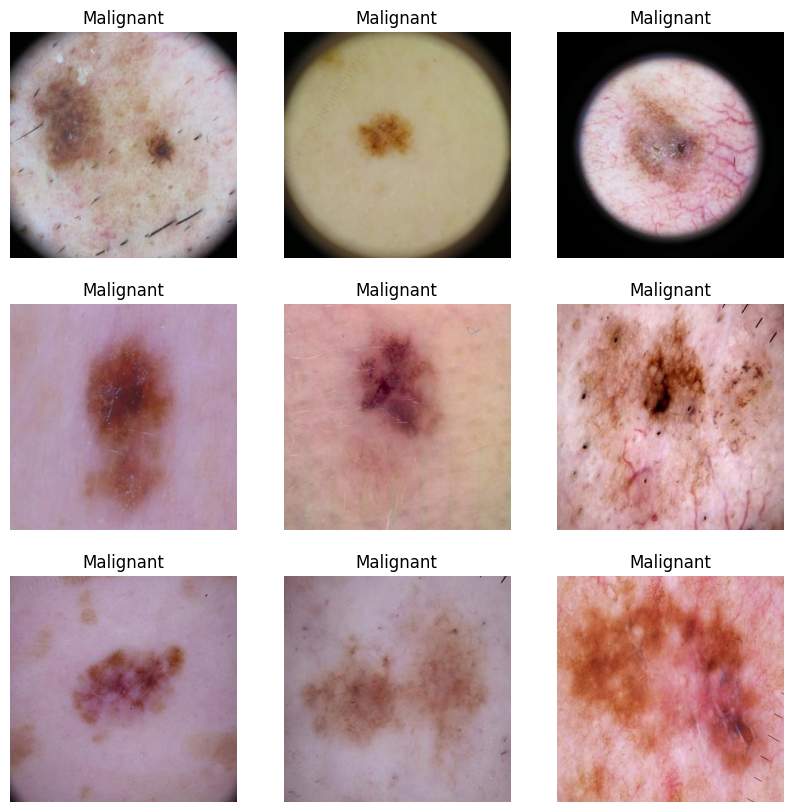

In [4]:
from matplotlib.image import imread

benign_folder = os.listdir(os.path.join(TRAIN_DIR, 'benign'))
benign_files = [f for f in benign_folder if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]

malignant_folder = os.listdir(os.path.join(TRAIN_DIR, 'malignant'))
malignant_files = [f for f in malignant_folder if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]

plt.figure(figsize=(10, 10))
for i, benign_file in enumerate(benign_files[:9]):
    image_path = os.path.join(TRAIN_DIR, 'benign', benign_file)
    plt.subplot(330 + 1 + i)
    image = imread(image_path)
    plt.imshow(image)
    plt.title('Benign')
    plt.axis('off')

plt.show()

plt.figure(figsize=(10, 10))
for i, malignant_file in enumerate(malignant_files[:9]):
    image_path = os.path.join(TRAIN_DIR, 'malignant', malignant_file)
    plt.subplot(330 + 1 + i)
    image = imread(image_path)
    plt.imshow(image)
    plt.title('Malignant')
    plt.axis('off')

plt.show()

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Step 2: Build the model using a pre-trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers first, then unfreeze last two blocks
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-8:]:  # Unfreeze last 8 layers (last two blocks)
    layer.trainable = True

# Add custom layers with dropout and L2 regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)  # 2 classes: benign and malignant

# Define the final model
model = Model(inputs=base_model.input, outputs=output)
model.summary()

# Step 3: Compile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 13,045,122 (49.76 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [ ]:
# Step 4: Custom callback for early stopping
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
class EarlyStopCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy >= 0.95 and accuracy > val_accuracy:
            print("\nStopping training as criteria met.")
            self.model.stop_training = True

In [ ]:
# Step 5: Add Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,          # Reduce learning rate by a factor of 0.2
    patience=3,          # Wait for 3 epochs before reducing the learning rate
    min_lr=1e-7          # Minimum learning rate
)

In [ ]:
# Step 6: Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=50,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(
                            "best_model.keras",
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True, mode="min"),
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True
                        ),
                        EarlyStopCallback(), reduce_lr
                    ])

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 10/301 ━━━━━━━━━━━━━━━━━━━━ 31:11 6s/step - accuracy: 0.5377 - loss: 2.8013

KeyboardInterrupt: 

In [ ]:
# Save the classification model
model.save(os.path.join(DATA_DIR, "final_model.keras"))

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [15]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model_path = "final_model.keras"  # Adjust the path if needed
model = tf.keras.models.load_model(model_path)

# Image preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load and resize
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# # Function to classify images
# def classify_image(image_path, model, confidence_threshold=0.7):
#     img_array = preprocess_image(image_path)
#     prediction = model.predict(img_array)[0][0]  # Get probability of positive class
#     confidence = max(prediction, 1 - prediction)  # Confidence is max probability

#     if confidence < confidence_threshold:
#         return "Invalid", confidence
#     else:
#         return ("Benign" if prediction<0.5 else "Malignant"), confidence

def classify_image(model, image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    
    # Predict using the model
    prediction = model.predict(img_array)  # Softmax output: [benign_prob, malignant_prob]
    
    # Ensure the model has 3 output classes (Benign, Malignant, Invalid)
    benign_prob = prediction[0][0]
    malignant_prob = prediction[0][1]

    # Determine classification
    if max(benign_prob, malignant_prob) < 0.8:
        return "Invalid Image", max(benign_prob, malignant_prob)
    else:
        return ("Benign" if benign_prob > malignant_prob else "Malignant"), max(benign_prob, malignant_prob)

# Testing images
image_paths = {
   "Malignant_1(Malignant)" : r"C:\Users\User\Downloads\malignant_1.jpeg", 
   "Malignant_2(Malignant)" : r"C:\Users\User\Downloads\malignant_2.jpeg",  
   "Malignant_3(Malignant)" : r"C:\Users\User\Downloads\malignant_3.jpeg",   
   "Malignant_4(Malignant)" : r"C:\Users\User\Downloads\malignant_4.jpeg", 
   "Benign_1(Benign)" :r"C:\Users\User\Downloads\benign_!.jpeg",
   "Benign_2(Benign)" :r"C:\Users\User\Downloads\benign_2.jpeg",
   "Benign_3(Benign)" :r"C:\Users\User\Downloads\benign_3.jpeg",
   "Benign_4(Benign)" :r"C:\Users\User\Downloads\benign_4.jpeg",
   "Face(Invalid)" :  r"C:\Users\User\Downloads\face.png",
   "Jumpscare(Invalid)" : r"C:\Users\User\Downloads\jumpscare.jpeg",
   "Plot_1(Invalid)" : r"C:\Users\User\Downloads\AccuracyLossPlot.png",
   "Plot_2(Invalid)" : r"C:\Users\User\Downloads\loss_plot.png",
   "Dragonfly_1(Invalid)" : r"C:\Users\User\Downloads\dragonfly_test.jpeg",
   "Dragonfly_2(Invalid)" : r"C:\Users\User\Downloads\dragonfly_test2.jpeg",
   "Grasshopper_1(Invalid)" : r"C:\Users\User\Downloads\grasshopper_test.jpg",
   "Grasshopper_2(Invalid)" : r"C:\Users\User\Downloads\grasshopper_test2.jpg",
}

# # Running classification
# for name, path in image_paths.items():
#     result, conf = classify_image(path, model)
#     print(f"{name}: Classified as {result} with confidence {conf:.2f}")

# Running classification
for name, path in image_paths.items():
    result, conf = classify_image(model, path)
    print(f"{name}: Classified as {result} with confidence {conf:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Malignant_1(Malignant): Classified as Malignant with confidence 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Malignant_2(Malignant): Classified as Invalid Image with confidence 0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Malignant_3(Malignant): Classified as Malignant with confidence 0.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Malignant_4(Malignant): Classified as Malignant with confidence 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Benign_1(Benign): Classified as Invalid Image with confidence 0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Benign_2(Benign): Classified as Malignant with confidence 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Benign_3(Benign): Classified as Benign with confidence 0.95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Benign_4(Benign): Classified as Benign with confidence 0.95
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Face(Invalid): Classified as Invalid Image with confidence 0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Jumpscare(Invali

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Load the trained model
model_path = "final_model.keras"  # Adjust the path if needed
model = tf.keras.models.load_model(model_path)

# Image preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load and resize
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


def classify_image(model, image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    
    # Predict using the model
    prediction = model.predict(img_array)  # Softmax output: [benign_prob, malignant_prob]
    
    # Ensure the model has 3 output classes (Benign, Malignant, Invalid)
    benign_prob = prediction[0][0]
    malignant_prob = prediction[0][1]

    # Determine classification
    if max(benign_prob, malignant_prob) < 0.7:
        return "Invalid Image", max(benign_prob, malignant_prob)
    else:
        return ("Benign" if benign_prob > malignant_prob else "Malignant"), max(benign_prob, malignant_prob)

# Function to classify all images in a folder
def classify_images_in_folder(model, folder_path, output_file="benign_predictions.txt"):
    results = []
    print("\n **Classifying images...**\n")

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if file_path.lower().endswith((".png", ".jpg", ".jpeg")):  # Process only image files
            label, confidence = classify_image(model, file_path)
            result_text = f"{filename}: Classified as {label} with confidence {confidence:.2f}"
            results.append(result_text)
            print(result_text)  # Display results in console

    # Save results to a file
    with open(output_file, "w") as f:
        f.write("\n".join(results))

    print(f"\n Predictions saved to {output_file}")

# Run classification on a folder
folder_path = r"C:\Users\User\Documents\VS_Code\Cancer_Project\benign_model_testing" # Change this to your folder path
classify_images_in_folder(model, folder_path)

# # Running classification
# for name, path in image_paths.items():
#     result, conf = classify_image(model, path)
#     print(f"{name}: Classified as {result} with confidence {conf:.2f}")


 **Classifying images...**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
melanoma_10000.jpg: Classified as Benign with confidence 0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
melanoma_10001.jpg: Classified as Benign with confidence 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
melanoma_10002.jpg: Classified as Benign with confidence 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
melanoma_10003.jpg: Classified as Benign with confidence 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
melanoma_10004.jpg: Classified as Benign with confidence 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
melanoma_10005.jpg: Classified as Benign with confidence 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
melanoma_10006.jpg: Classified as Benign with confidence 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
melanoma_10007.jpg: Classified as Invalid Image with confidence 0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
melanoma_10008.jpg: Classified as Invalid Image with confidence 0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
melanoma_100

NameError: name 'image_paths' is not defined

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Load the trained model
model_path = "final_model.keras"  # Adjust the path if needed
model = tf.keras.models.load_model(model_path)

# Image preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load and resize
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array


def classify_image(model, image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    
    # Predict using the model
    prediction = model.predict(img_array)  # Softmax output: [benign_prob, malignant_prob]
    
    # Ensure the model has 3 output classes (Benign, Malignant, Invalid)
    benign_prob = prediction[0][0]
    malignant_prob = prediction[0][1]

    # Determine classification
    if max(benign_prob, malignant_prob) < 0.8:
        return "Invalid Image", max(benign_prob, malignant_prob)
    else:
        return ("Benign" if benign_prob > malignant_prob else "Malignant"), max(benign_prob, malignant_prob)

# Function to classify all images in a folder
def classify_images_in_folder(model, folder_path, output_file="malignant_predictions.txt"):
    results = []
    print("\n **Classifying images...**\n")

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        if file_path.lower().endswith((".png", ".jpg", ".jpeg")):  # Process only image files
            label, confidence = classify_image(model, file_path)
            result_text = f"{filename}: Classified as {label} with confidence {confidence:.2f}"
            results.append(result_text)
            print(result_text)  # Display results in console

    # Save results to a file
    with open(output_file, "w") as f:
        f.write("\n".join(results))

    print(f"\n Predictions saved to {output_file}")

# Run classification on a folder
folder_path = r"C:\Users\User\Documents\VS_Code\Cancer_Project\malignant_model_testing" # Change this to your folder path
classify_images_in_folder(model, folder_path)

# # Running classification
# for name, path in image_paths.items():
#     result, conf = classify_image(model, path)
#     print(f"{name}: Classified as {result} with confidence {conf:.2f}")


 **Classifying images...**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
melanoma_10105.jpg: Classified as Benign with confidence 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
melanoma_10106.jpg: Classified as Malignant with confidence 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
melanoma_10107.jpg: Classified as Benign with confidence 0.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
melanoma_10108.jpg: Classified as Benign with confidence 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
melanoma_10109.jpg: Classified as Invalid Image with confidence 0.70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
melanoma_10110.jpg: Classified as Invalid Image with confidence 0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
melanoma_10111.jpg: Classified as Malignant with confidence 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
melanoma_10112.jpg: Classified as Benign with confidence 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
melanoma_10113.jpg: Classified as Malignant with confidence 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


NameError: name 'image_paths' is not defined